In [38]:
import json
import logging
import os
from collections import defaultdict
from concurrent.futures import ThreadPoolExecutor, as_completed

import colorlog
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define a color formatter
formatter = colorlog.ColoredFormatter(
    "%(log_color)s%(levelname)s: %(message)s",
    log_colors={
        "DEBUG": "cyan",
        "INFO": "green",
        "WARNING": "yellow",
        "ERROR": "red",
        "CRITICAL": "bold_red",
    },
)

# Create a logger
logger = logging.getLogger(__name__)  # Use module-level logger
logger.setLevel(logging.INFO)
logger.propagate = False  # Prevent propagation to root logger

# Remove all existing handlers (even from previous executions)
logger.handlers.clear()

# Create a stream handler and set the formatter
handler = logging.StreamHandler()
handler.setFormatter(formatter)

# Add the new handler
logger.addHandler(handler)

In [39]:
monitored_metrics = ["Accuracy", "Precision", "Recall", "F1 Score"]
data_types = ["ast_cfg", "ast", "cfg"]
base_folder = "../explanations"
columns = ["Data Type"] + monitored_metrics
sns.set_palette("tab10")

In [40]:
def get_json_files(directory):
    """Retrieves all JSON file paths in a given directory."""
    try:
        return [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith(".json")]
    except FileNotFoundError:
        logger.warning(f"Directory not found: {directory}")
        return []


def load_json(file_path):
    """Loads a JSON file and returns its content."""
    try:
        with open(file_path, "r", encoding="utf-8") as file:
            return json.load(file)
    except (json.JSONDecodeError, FileNotFoundError, KeyError) as e:
        logger.error(f"Error processing file '{file_path}': {e}")
        return None


def compute_category_metrics(directory, gt_category):
    """
    Computes Accuracy, Precision, Recall, and F1-score for a category using sklearn.

    :param directory: Path to the directory containing JSON log files.
    :param gt_category: The ground truth category.
    :return: Dictionary containing accuracy, precision, recall, and f1-score.
    """
    json_files = get_json_files(directory)
    total_files = len(json_files)

    if total_files == 0:
        return {"Accuracy": 0.0, "Precision": 0.0, "Recall": 0.0, "F1 Score": 0.0, "Total": 0}

    gt_category = gt_category.lower()
    y_true, y_pred = [], []

    for file in json_files:
        content = load_json(file)
        if not content:
            continue

        predicted_category = content.get("classification", "").lower()
        y_true.append(gt_category)
        y_pred.append(predicted_category)

    # Compute metrics using sklearn
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average="binary", pos_label=gt_category, zero_division=0)
    recall = recall_score(y_true, y_pred, average="binary", pos_label=gt_category, zero_division=0)
    f1 = f1_score(y_true, y_pred, average="binary", pos_label=gt_category, zero_division=0)

    return {"Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1 Score": f1, "Total": total_files}


def compute_overall_metrics(results):
    """
    Computes overall Accuracy, Precision, Recall, and F1-score across multiple categories.

    :param results: Dictionary of category-wise metric results.
    :return: Dictionary containing overall accuracy, precision, recall, and f1-score.
    """
    total_all = sum(res["Total"] for res in results.values())

    if total_all == 0:
        logger.warning("No JSON files found in any category.")
        return {"Accuracy": 0.0, "Precision": 0.0, "Recall": 0.0, "F1 Score": 0.0}

    # Weighted average of all metrics
    weighted_metrics = {key: sum(res[key] * res["Total"] for res in results.values()) / total_all for key in
                        monitored_metrics}

    return weighted_metrics

# Baseline

In [41]:
# Base folder containing the cross-validation fold directories
base_folder = "../explanations/baseline"
num_folds = 3

# --- 1. Identify Models and Categories ---
# Assume models are consistent across folds. Get model list from the first fold.
fold_dirs = [os.path.join(base_folder, f"cv_{i + 1}") for i in range(num_folds)]
first_fold_dir = fold_dirs[0]

if not os.path.exists(first_fold_dir):
    raise FileNotFoundError(f"First fold directory not found: {first_fold_dir}")

# List models available in the first fold (assuming consistency)
available_models = [
    model_dir for model_dir in os.listdir(first_fold_dir)
    if os.path.isdir(os.path.join(first_fold_dir, model_dir))
]

if not available_models:
    print(f"No model directories found in {first_fold_dir}")
    exit()

print(f"Found models: {available_models}")

# --- 2. Process each model across all folds ---
baseline_results = {}  # To store aggregated mean/std dev results

for model_name in available_models:
    print(f"\n===== PROCESSING MODEL: {model_name} =====")

    # Store metrics from each fold for this model to calculate mean/std later
    # Structure: { 'category_name': {'MetricName': [val_fold1, val_fold2, ...]}, 'overall': {'MetricName': [...]}}
    model_fold_metrics = defaultdict(lambda: defaultdict(list))
    all_categories_across_folds = set()  # Keep track of all categories seen for this model

    # Iterate through each fold's directory for the current model
    for i, fold_dir in enumerate(fold_dirs):
        fold_num = i + 1
        model_path_in_fold = os.path.join(fold_dir, model_name)
        print(f"\n  --- Processing Fold {fold_num} ({model_path_in_fold}) ---")

        if not os.path.exists(model_path_in_fold):
            print(f"  Warning: Model directory not found in this fold: {model_path_in_fold}")
            # Store NaN or skip metrics for this fold? Decide based on requirements.
            # For simplicity, we'll skip appending metrics for this fold if the model dir is missing.
            continue  # Skip to the next fold for this model

        # Automatically detect categories as subdirectories within this fold's model dir
        try:
            categories_in_fold = {
                subdir: os.path.join(model_path_in_fold, subdir)
                for subdir in os.listdir(model_path_in_fold)
                if os.path.isdir(os.path.join(model_path_in_fold, subdir))
            }
        except FileNotFoundError:
            print(f"  Error listing categories in: {model_path_in_fold}")
            continue  # Skip fold if error

        if not categories_in_fold:
            print(f"  Warning: No category subdirectories found in {model_path_in_fold}")
            # Decide how to handle: skip fold or record zero metrics? Skip for now.
            continue

        # Update the set of all categories seen across folds for this model
        all_categories_across_folds.update(categories_in_fold.keys())

        # Compute metrics for each category *within this fold*
        results_this_fold = {}
        for category, path in categories_in_fold.items():
            cat_metrics = compute_category_metrics(path, category)
            if cat_metrics:  # Only store if metrics were computed successfully
                results_this_fold[category] = cat_metrics
                # Append metrics to the aggregation dictionary
                for metric_name, value in cat_metrics.items():
                    if metric_name != 'Total':  # Don't average 'Total' files
                        model_fold_metrics[category][metric_name].append(value)
            else:
                print(f"    Skipping metrics for category '{category}' due to computation issues.")

        # Compute overall metrics *for this fold*
        overall_metrics_this_fold = compute_overall_metrics(results_this_fold)

        if overall_metrics_this_fold:
            print(f"  Fold {fold_num} Overall - "
                  f"Acc: {overall_metrics_this_fold.get('Accuracy', 0):.2%}, "
                  f"Prec: {overall_metrics_this_fold.get('Precision', 0):.2%}, "
                  f"Rec: {overall_metrics_this_fold.get('Recall', 0):.2%}, "
                  f"F1: {overall_metrics_this_fold.get('F1 Score', 0):.2%}")

            # Append overall metrics to the aggregation dictionary
            for metric_name, value in overall_metrics_this_fold.items():
                model_fold_metrics['overall'][metric_name].append(value)
        else:
            print(f"  Warning: Could not compute overall metrics for Fold {fold_num}.")

    # --- 3. Calculate Mean and Std Dev for the current model ---
    print(f"\n  --- Aggregated Results for Model: {model_name} (across {num_folds} folds) ---")
    model_summary = {}

    # Ensure consistent processing order
    sorted_categories = sorted(list(all_categories_across_folds))

    category_keys_to_process = sorted_categories + ['overall']  # Process categories first, then overall

    for key in category_keys_to_process:  # key is either category name or 'overall'
        if key not in model_fold_metrics:
            print(f"    No results found for '{key}' across any fold.")
            continue

        summary_metrics = {}
        print(f"    {key.capitalize()}:")
        metrics_to_aggregate = list(model_fold_metrics[key].keys())

        for metric in metrics_to_aggregate:
            values = model_fold_metrics[key][metric]
            if len(values) == num_folds:
                mean_val = np.mean(values)
                std_dev = np.std(values)
                summary_metrics[f"{metric}_mean"] = mean_val
                summary_metrics[f"{metric}_std"] = std_dev
                print(f"      {metric}: {mean_val:.2%} ± {std_dev:.2%}")
            elif len(values) > 0:
                # Handle cases where a category/overall metric was missing in some folds
                mean_val = np.mean(values)
                std_dev = np.std(values)
                summary_metrics[f"{metric}_mean"] = mean_val
                summary_metrics[f"{metric}_std"] = std_dev
                print(
                    f"      {metric}: {mean_val:.2%} ± {std_dev:.2%} (calculated from {len(values)}/{num_folds} folds)")
            else:
                # No values found for this metric at all
                summary_metrics[f"{metric}_mean"] = np.nan
                summary_metrics[f"{metric}_std"] = np.nan
                print(f"      {metric}: N/A (No data found)")

        model_summary[key] = summary_metrics

    # Store the summary for this model
    baseline_results[model_name] = model_summary

baseline_summary = {}

# --- 4. (Optional) Print Final Summary Table ---
print("\n\n===== FINAL CROSS-VALIDATION SUMMARY =====")
for model_name, summary in baseline_results.items():
    print(f"\n--- Model: {model_name} ---")
    if 'overall' in summary:
        baseline_summary[model_name] = summary['overall']
        overall = summary['overall']
        print(f"  Overall Performance:")
        print(f"    Accuracy:  {overall.get('Accuracy_mean', np.nan):.2%} ± {overall.get('Accuracy_std', np.nan):.2%}")
        print(
            f"    Precision: {overall.get('Precision_mean', np.nan):.2%} ± {overall.get('Precision_std', np.nan):.2%}")
        print(f"    Recall:    {overall.get('Recall_mean', np.nan):.2%} ± {overall.get('Recall_std', np.nan):.2%}")
        print(f"    F1 Score:  {overall.get('F1 Score_mean', np.nan):.2%} ± {overall.get('F1 Score_std', np.nan):.2%}")

pd.DataFrame(baseline_summary).transpose().to_csv("baseline_classification.csv")
print("\nProcessing Complete.")

Found models: ['gpt-4o', 'o3-mini']

===== PROCESSING MODEL: gpt-4o =====

  --- Processing Fold 1 (../explanations/baseline/cv_1/gpt-4o) ---
  Fold 1 Overall - Acc: 85.23%, Prec: 100.00%, Rec: 85.23%, F1: 91.88%

  --- Processing Fold 2 (../explanations/baseline/cv_2/gpt-4o) ---
  Fold 2 Overall - Acc: 88.64%, Prec: 100.00%, Rec: 88.64%, F1: 93.91%

  --- Processing Fold 3 (../explanations/baseline/cv_3/gpt-4o) ---
  Fold 3 Overall - Acc: 87.36%, Prec: 100.00%, Rec: 87.36%, F1: 93.25%

  --- Aggregated Results for Model: gpt-4o (across 3 folds) ---
    Reentrant:
      Accuracy: 93.33% ± 3.77%
      Precision: 100.00% ± 0.00%
      Recall: 93.33% ± 3.77%
      F1 Score: 96.51% ± 2.05%
    Safe:
      Accuracy: 84.59% ± 2.63%
      Precision: 100.00% ± 0.00%
      Recall: 84.59% ± 2.63%
      F1 Score: 91.63% ± 1.56%
    Overall:
      Accuracy: 87.07% ± 1.41%
      Precision: 100.00% ± 0.00%
      Recall: 87.07% ± 1.41%
      F1 Score: 93.02% ± 0.84%

===== PROCESSING MODEL: o3-mini =

In [42]:
def load_json(file_path):
    """Load a JSON file and return its contents."""
    logger.debug(f"Loading JSON file: {file_path}")
    try:
        with open(file_path, 'r') as f:
            return json.load(f)
    except Exception as e:
        logger.error(f"Error loading JSON file {file_path}: {e}")
        return None


def get_ground_truth_from_path(contract_path):
    """Determine the ground truth label based on the parent folder name."""
    label = "reentrant" if "reentrant" in contract_path else "safe" if "safe" in contract_path else None
    return label


def collect_predictions(contract_dir):
    """Collect labels from JSON files (excluding classification.json)."""
    predictions = []
    files = [f for f in os.listdir(contract_dir) if f.endswith(".json") and f != "classification.json"]

    mislabelled = [
        "0xc9109587a84522508e432daf4e1c5d64893dc182",
        "0x607bad7a2969019ade64cb1b74f60fffa20cc3e5",
        "0bf0ebe31b1e67618bc28a9d3738a2e4",
        "0x33813c2f2aab62ac88c234858a1f08448424828f",
        "0x0ad8f9bb50f4a04de224acf3345892147757f173",
        "ef9a3b92a5629baddf4c912b91bbe929"
    ]

    for f in files:
        for m in mislabelled:
            if m in f:
                print(f"    Mislabelling Detected {m}: {contract_dir}/{f}")

    with ThreadPoolExecutor() as executor:
        future_to_file = {executor.submit(load_json, os.path.join(contract_dir, file)): file for file in files}
        for future in as_completed(future_to_file):
            data = future.result()
            if data and "label" in data:
                predictions.append(data["label"])

    return predictions


def process_contract(root):
    """Process a single contract directory."""
    ground_truth = get_ground_truth_from_path(root)
    classification_file = os.path.join(root, "classification.json")

    y_true_class, y_pred_class = None, None
    y_true_anal, y_pred_anal = [], []

    if os.path.exists(classification_file):
        classification_data = load_json(classification_file)
        contract_label = classification_data.get("classification", "").lower()

        if contract_label:
            y_true_class, y_pred_class = ground_truth, contract_label

        predictions = collect_predictions(root)
        y_true_anal = [ground_truth] * len(predictions)
        y_pred_anal = predictions

    return y_true_class, y_pred_class, y_true_anal, y_pred_anal


def compute_metrics(y_true, y_pred, metric_name):
    if not y_true:
        logger.warning(f"No data available for {metric_name} computation.")
        return 0, 0, 0, 0
    return (
        accuracy_score(y_true, y_pred),
        precision_score(y_true, y_pred, pos_label="reentrant", average='binary'),
        recall_score(y_true, y_pred, pos_label="reentrant", average='binary'),
        f1_score(y_true, y_pred, pos_label="reentrant", average='binary')
    )


def evaluate(base_dir):
    """Compute accuracy, precision, recall, and F1-score for contract classification using parallel processing."""
    logger.debug(f"Starting evaluation on base directory: {base_dir}")

    contract_paths = [os.path.join(root) for root, _, _ in os.walk(base_dir) if
                      any(sub in root for sub in ["reentrant", "safe"])]

    y_true_analysis, y_pred_analysis = [], []
    y_true_classification, y_pred_classification = [], []

    with ThreadPoolExecutor() as executor:
        futures = {executor.submit(process_contract, root): root for root in contract_paths}
        for future in as_completed(futures):
            y_true_class, y_pred_class, y_true_anal, y_pred_anal = future.result()
            if y_true_class is not None:
                y_true_classification.append(y_true_class)
                y_pred_classification.append(y_pred_class)
            y_true_analysis.extend(y_true_anal)
            y_pred_analysis.extend(y_pred_anal)

    analysis_metrics = compute_metrics(y_true_analysis, y_pred_analysis, "analysis")
    classification_metrics = compute_metrics(y_true_classification, y_pred_classification, "classification")

    return analysis_metrics, classification_metrics


def process_results(base_directory):
    """Evaluate and extract analysis and classification metrics."""
    results = evaluate(base_directory)
    analysis_metrics, classification_metrics = results

    # Handle None values by replacing with NaN
    analysis_metrics = analysis_metrics if analysis_metrics else (np.nan, np.nan, np.nan, np.nan)
    classification_metrics = classification_metrics if classification_metrics else (np.nan, np.nan, np.nan, np.nan)

    return analysis_metrics, classification_metrics

# XRAG Models Evaluation

In [43]:
# --- Configuration ---
base_path = os.path.join("..", "explanations", "xrag")  # Base path containing cv_X folders
num_folds = 3
fold_prefix = "cv_"

# --- 1. Identify Folds and Models ---
fold_dirs = [os.path.join(base_path, f"{fold_prefix}{i + 1}") for i in range(num_folds)]
available_models = set()

# Find all unique model names present across folds
for fold_dir in fold_dirs:
    if not os.path.isdir(fold_dir):
        logger.warning(f"Fold directory not found: {fold_dir}, skipping.")
        continue
    try:
        models_in_fold = {
            item for item in os.listdir(fold_dir)
            if os.path.isdir(os.path.join(fold_dir, item))
        }
        if not available_models:
            available_models = models_in_fold  # Initialize with first fold's models
        else:
            available_models.intersection_update(models_in_fold)  # Keep only models present in *all* folds so far
    except FileNotFoundError:
        logger.warning(f"Error listing models in {fold_dir}")
    except Exception as e:
        logger.error(f"Error accessing {fold_dir}: {e}")

if not available_models:
    raise FileNotFoundError(f"No common model directories found across folds in {base_path}")

sorted_models = sorted(list(available_models))
logger.info(f"Found common models across folds: {sorted_models}")

# --- 2. Process models across folds and aggregate data ---

# Structure to hold raw metrics before aggregation:
# { model_name: { data_type: { 'analysis': { metric_idx: [fold1_val, ...]},
#                             'classification': { metric_idx: [fold1_val, ...]}
#                           }
#               }
# }
temp_results = defaultdict(lambda: defaultdict(lambda: {
    'analysis': defaultdict(list),
    'classification': defaultdict(list)
}))

for model_name in sorted_models:
    logger.info(f"\n===== PROCESSING MODEL: {model_name} =====")
    for dt in data_types:
        logger.debug(f"  -- Processing DataType: {dt} --")
        for i, fold_dir in enumerate(fold_dirs):
            fold_num = i + 1
            data_dir = os.path.join(fold_dir, model_name, dt)
            logger.debug(f"    Fold {fold_num}: Checking path {data_dir}")

            # Process results for this specific model/datatype/fold
            analysis_metrics, classification_metrics = process_results(data_dir)

            # Store results if successfully processed
            if analysis_metrics is not None:
                if len(analysis_metrics) != len(monitored_metrics):
                    logger.error(
                        f"    Model '{model_name}', DataType '{dt}', Fold {fold_num}: Analysis metrics length mismatch! Expected {len(monitored_metrics)}, Got {len(analysis_metrics)}. Skipping.")
                else:
                    for metric_idx, value in enumerate(analysis_metrics):
                        temp_results[model_name][dt]['analysis'][metric_idx].append(value)

            if classification_metrics is not None:
                if len(classification_metrics) != len(monitored_metrics):
                    logger.error(
                        f"    Model '{model_name}', DataType '{dt}', Fold {fold_num}: Classification metrics length mismatch! Expected {len(monitored_metrics)}, Got {len(classification_metrics)}. Skipping.")
                else:
                    for metric_idx, value in enumerate(classification_metrics):
                        temp_results[model_name][dt]['classification'][metric_idx].append(value)

# --- 3. Calculate Mean/Std Dev and Create Final DataFrames ---

# Dictionary to hold final DataFrames for each model
final_analysis_results = {}
final_classification_results = {}

# Define new column names for the aggregated DataFrames
agg_columns = ['DataType']
for name in monitored_metrics:
    agg_columns.extend([f"{name}_mean", f"{name}_std"])

for model_name in sorted_models:
    analysis_data_agg = []
    classification_data_agg = []

    logger.info(f"\n--- Aggregating results for Model: {model_name} ---")

    for dt in data_types:
        if dt not in temp_results[model_name]:
            logger.warning(
                f"  DataType '{dt}' not found or had no results for model '{model_name}'. Skipping aggregation.")
            continue

        logger.debug(f"  Aggregating for DataType: {dt}")
        analysis_row = [dt]
        classification_row = [dt]

        valid_analysis = True
        valid_classification = True

        # Aggregate analysis metrics
        analysis_metrics_dict = temp_results[model_name][dt]['analysis']
        for metric_idx in range(len(monitored_metrics)):
            values = analysis_metrics_dict.get(metric_idx, [])
            if len(values) > 0:
                mean_val = np.mean(values)
                std_val = np.std(values)
                analysis_row.extend([mean_val, std_val])
                if len(values) < num_folds:
                    logger.warning(
                        f"    Model '{model_name}', DataType '{dt}', Analysis Metric '{monitored_metrics[metric_idx]}': Calculated from {len(values)}/{num_folds} folds.")
            else:
                logger.error(
                    f"    Model '{model_name}', DataType '{dt}', Analysis Metric '{monitored_metrics[metric_idx]}': No data found across folds! Filling with NaN.")
                analysis_row.extend([np.nan, np.nan])
                valid_analysis = False  # Mark row as potentially incomplete

        # Aggregate classification metrics
        classification_metrics_dict = temp_results[model_name][dt]['classification']
        for metric_idx in range(len(monitored_metrics)):
            values = classification_metrics_dict.get(metric_idx, [])
            if len(values) > 0:
                mean_val = np.mean(values)
                std_val = np.std(values)
                classification_row.extend([mean_val, std_val])
                if len(values) < num_folds:
                    logger.warning(
                        f"    Model '{model_name}', DataType '{dt}', Classification Metric '{monitored_metrics[metric_idx]}': Calculated from {len(values)}/{num_folds} folds.")
            else:
                logger.error(
                    f"    Model '{model_name}', DataType '{dt}', Classification Metric '{monitored_metrics[metric_idx]}': No data found across folds! Filling with NaN.")
                classification_row.extend([np.nan, np.nan])
                valid_classification = False  # Mark row as potentially incomplete

        # Only add row if data was found (check length > 1 because DataType name is included)
        if len(analysis_row) > 1 and valid_analysis:  # or decide based on your needs if partial data is ok
            analysis_data_agg.append(analysis_row)
        if len(classification_row) > 1 and valid_classification:  # or decide based on your needs if partial data is ok
            classification_data_agg.append(classification_row)

    # Create DataFrames for the current model
    analysis_df = pd.DataFrame(analysis_data_agg, columns=agg_columns)
    classification_df = pd.DataFrame(classification_data_agg, columns=agg_columns)

    # Store DataFrames in dictionaries
    final_analysis_results[model_name] = analysis_df
    final_classification_results[model_name] = classification_df

    # Display tables
    logger.info(f"\nAggregated Analysis Metrics for {model_name} (Mean ± Std Dev across {num_folds} folds)")
    if not analysis_df.empty:
        display(analysis_df)
    else:
        logger.info("  (No valid aggregated analysis data to display)")

    logger.info(f"\nAggregated Classification Metrics for {model_name} (Mean ± Std Dev across {num_folds} folds)")
    if not classification_df.empty:
        display(classification_df)
    else:
        logger.info("  (No valid aggregated classification data to display)")

# --- 4. Final Results ---
# The final aggregated DataFrames are now stored in:
# final_analysis_results (dict: model_name -> DataFrame)
# final_classification_results (dict: model_name -> DataFrame)

logger.info("\n\n===== Cross-Validation Processing Complete =====")
logger.info(f"Aggregated analysis results stored in final_analysis_results")
logger.info(f"Aggregated classification results stored in final_classification_results")

# Example: Accessing the results for a specific model
# some_model = sorted_models[0]
# if some_model in final_analysis_results:
#     print(f"\nAccessing analysis results for {some_model}:")
#     print(final_analysis_results[some_model])

# --- 5. Save Classification Results to CSV ---

# Define an output directory for the CSV files (optional, but good practice)
# You could save it relative to the base_path or in the current working directory
output_csv_dir = os.path.join(base_path, "aggregated_csv_results")
# Or simply: output_csv_dir = "aggregated_csv_results" to save in the script's run directory

# Create the output directory if it doesn't exist
os.makedirs(output_csv_dir, exist_ok=True)
logger.info(f"\n\n===== Saving Aggregated Classification Results to CSV in '{output_csv_dir}' =====")

# Iterate through the dictionary containing the classification DataFrames
for model_name, classification_df in final_classification_results.items():
    if not classification_df.empty:
        # Construct the output filename
        output_filename = os.path.join(output_csv_dir, f"classification_results_{model_name}.csv")

        try:
            # Save the DataFrame to CSV
            # index=False prevents pandas from writing the DataFrame index as a column
            classification_df.to_csv(output_filename, index=False)
            logger.info(f"Successfully saved classification results for '{model_name}' to: {output_filename}")
        except Exception as e:
            logger.error(f"Failed to save CSV for model '{model_name}'. Error: {e}")
    else:
        logger.warning(f"Skipping CSV export for model '{model_name}' because its classification DataFrame is empty.")

logger.info("===== CSV Export Finished =====")

INFO: Found common models across folds: ['gpt-4o', 'o3-mini']
INFO: 
===== PROCESSING MODEL: gpt-4o =====
INFO: 
===== PROCESSING MODEL: o3-mini =====
INFO: 
--- Aggregating results for Model: gpt-4o ---
INFO: 
Aggregated Analysis Metrics for gpt-4o (Mean ± Std Dev across 3 folds)


,DataType,Accuracy_mean,Accuracy_std,Precision_mean,Precision_std,Recall_mean,Recall_std,F1 Score_mean,F1 Score_std
0,ast_cfg,0.000000,0.000000,0.00000,0.000000,0.00,0.000000,0.000000,0.000000
1,ast,0.000000,0.000000,0.00000,0.000000,0.00,0.000000,0.000000,0.000000
2,cfg,0.626147,0.006978,0.25385,0.020813,0.16,0.010887,0.196251,0.014233


INFO: 
Aggregated Classification Metrics for gpt-4o (Mean ± Std Dev across 3 folds)


,DataType,Accuracy_mean,Accuracy_std,Precision_mean,Precision_std,Recall_mean,Recall_std,F1 Score_mean,F1 Score_std
0,ast_cfg,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.00000
1,ast,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.00000
2,cfg,0.847919,0.014044,0.652857,0.020993,1.0,0.0,0.789778,0.01544


INFO: 
--- Aggregating results for Model: o3-mini ---
INFO: 
Aggregated Analysis Metrics for o3-mini (Mean ± Std Dev across 3 folds)


,DataType,Accuracy_mean,Accuracy_std,Precision_mean,Precision_std,Recall_mean,Recall_std,F1 Score_mean,F1 Score_std
0,ast_cfg,0.000000,0.000000,0.00000,0.000000,0.00,0.000000,0.000000,0.000000
1,ast,0.000000,0.000000,0.00000,0.000000,0.00,0.000000,0.000000,0.000000
2,cfg,0.626147,0.006978,0.25385,0.020813,0.16,0.010887,0.196251,0.014233


INFO: 
Aggregated Classification Metrics for o3-mini (Mean ± Std Dev across 3 folds)


,DataType,Accuracy_mean,Accuracy_std,Precision_mean,Precision_std,Recall_mean,Recall_std,F1 Score_mean,F1 Score_std
0,ast_cfg,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000
1,ast,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000
2,cfg,0.950496,0.014523,0.985507,0.020496,0.84,0.056569,0.905491,0.030648


INFO: 

===== Cross-Validation Processing Complete =====
INFO: Aggregated analysis results stored in final_analysis_results
INFO: Aggregated classification results stored in final_classification_results
INFO: 

===== Saving Aggregated Classification Results to CSV in '../explanations/xrag/aggregated_csv_results' =====
INFO: Successfully saved classification results for 'gpt-4o' to: ../explanations/xrag/aggregated_csv_results/classification_results_gpt-4o.csv
INFO: Successfully saved classification results for 'o3-mini' to: ../explanations/xrag/aggregated_csv_results/classification_results_o3-mini.csv
INFO: ===== CSV Export Finished =====


# Effect of Data Type

INFO: Plotting for models: ['gpt-4o', 'o3-mini']
INFO: Using data types: ['ast_cfg', 'ast', 'cfg']
INFO: Plotting metrics: ['Accuracy', 'Precision', 'Recall', 'F1 Score']


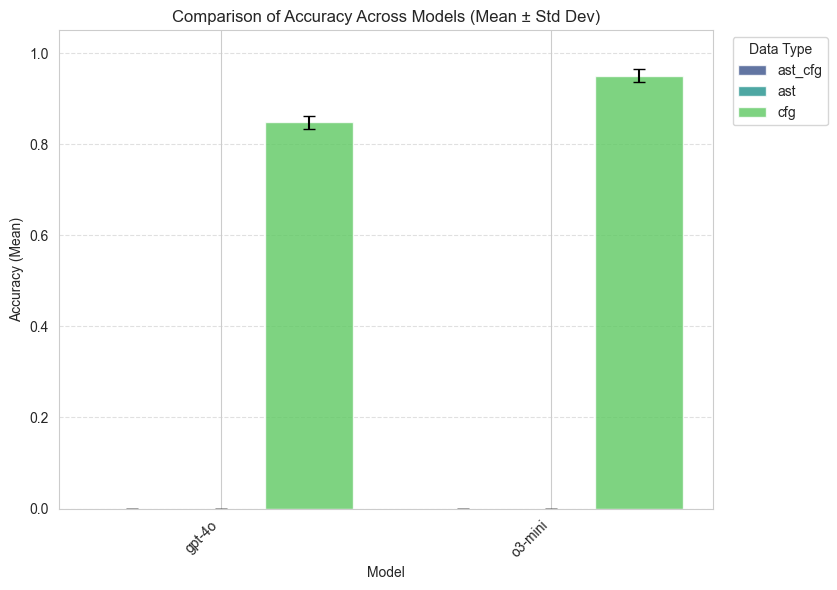

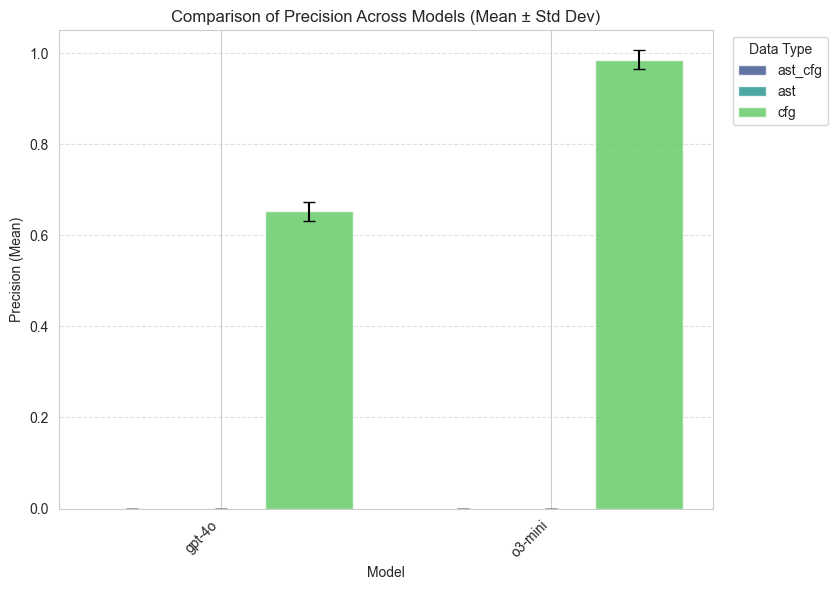

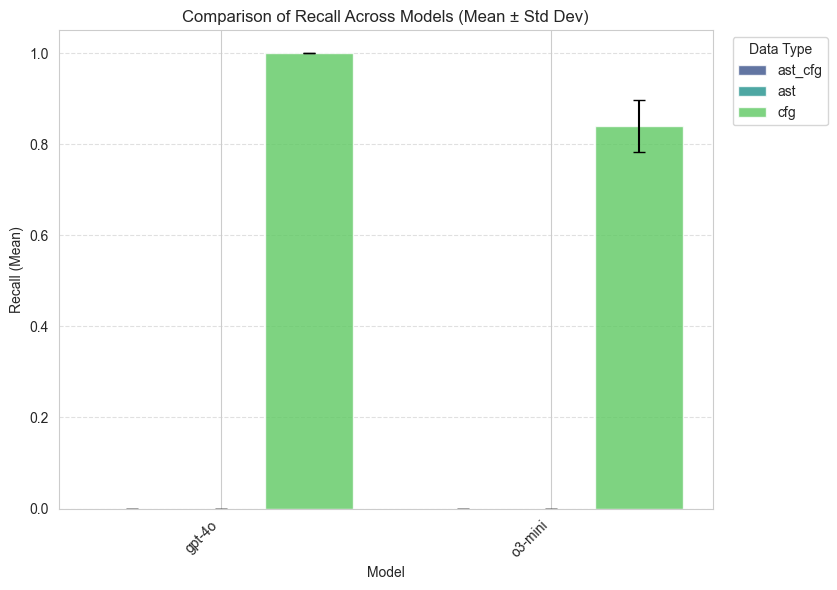

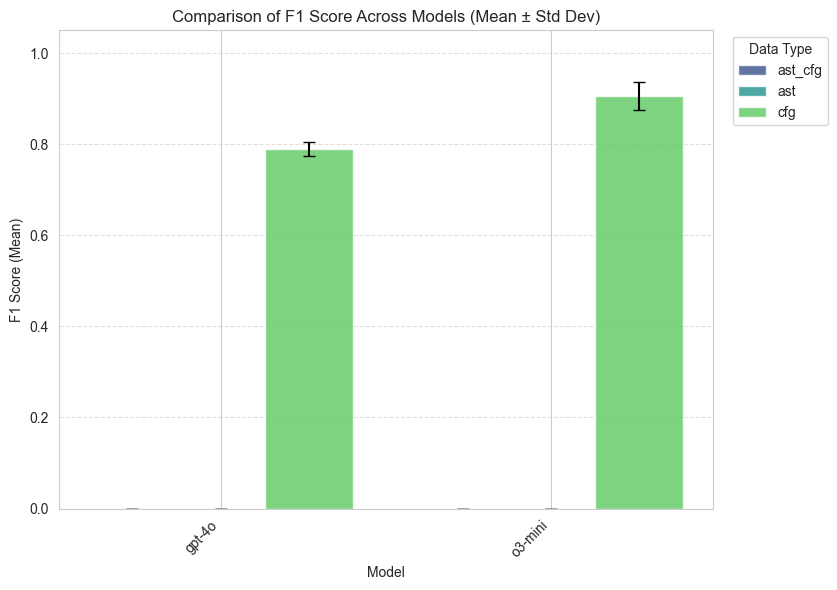

In [44]:
# Check if the results dictionary exists and is populated
if 'final_classification_results' not in locals() or not isinstance(final_classification_results,
                                                                    dict) or not final_classification_results:
    logger.error("Error: 'final_classification_results' dictionary not found, is not a dictionary, or is empty.")
# Check if essential configuration lists exist
elif 'data_types' not in locals() or not data_types:
    logger.error("Error: 'data_types' list not found or is empty.")
elif 'monitored_metrics' not in locals() or not monitored_metrics:
    logger.error("Error: 'monitored_metrics' list not found or is empty.")
else:
    # Filter models based on the original criteria, now using the keys from the new dictionary
    models = [
        m for m in final_classification_results.keys()
        if not ("_k" in m or m.startswith("r"))  # Adjust filter if needed
    ]

    # Proceed only if there are models left after filtering
    if not models:
        logger.warning("No models match the filter criteria. No plots will be generated.")
    else:
        logger.info(f"Plotting for models: {models}")
        logger.info(f"Using data types: {data_types}")
        logger.info(f"Plotting metrics: {monitored_metrics}")

        # Check the exact name of the DataType column in the first valid model's DataFrame
        first_df = final_classification_results[models[0]]
        if "DataType" in first_df.columns:
            data_type_col_name = "DataType"
        elif "Data Type" in first_df.columns:
            data_type_col_name = "Data Type"
        else:
            logger.error("Could not find 'DataType' or 'Data Type' column in DataFrames. Cannot proceed with plotting.")
            # Set models to empty to prevent further processing
            models = []

    # Loop through each metric to create a separate plot
    for metric in monitored_metrics:
        if not models:  # Skip if no models or if DataType column check failed
            break

        plt.figure(figsize=(10, 6))  # Adjust figure size as needed

        # Define the column names for mean and standard deviation
        mean_col = f"{metric}_mean"
        std_col = f"{metric}_std"

        # Basic check if mean/std columns exist in the first model's DataFrame
        first_model_df = final_classification_results[models[0]]
        if mean_col not in first_model_df.columns or std_col not in first_model_df.columns:
            logger.warning(
                f"Metric columns '{mean_col}' or '{std_col}' not found in DataFrame for model '{models[0]}'. Skipping plot for metric '{metric}'.")
            plt.close()  # Close the figure created for this metric
            continue  # Skip to the next metric

        x = np.arange(len(models))  # Create base positions for the models on the x-axis
        num_data_types = len(data_types)
        total_width_per_model = 0.8  # Total width for all bars for one model
        width_per_bar = total_width_per_model / num_data_types  # Width of a single bar

        # Get distinct colors for each data type
        colors = sns.color_palette("viridis", num_data_types)

        # Iterate through each data type to plot its bars for all models
        for i, (data_type, color) in enumerate(zip(data_types, colors)):
            mean_values = []
            std_devs = []

            # Gather mean and std dev for the current data_type across all selected models
            for model in models:
                model_df = final_classification_results[model]
                # Find the row corresponding to the current data type
                row = model_df.loc[model_df[data_type_col_name] == data_type]

                if not row.empty:
                    # Safely extract mean and std dev, defaulting to NaN if columns are missing (though checked earlier)
                    mean_val = row.iloc[0].get(mean_col, np.nan)
                    std_val = row.iloc[0].get(std_col, np.nan)
                    mean_values.append(mean_val)
                    # Use 0 for std dev if it's NaN but mean is valid (or handle as needed)
                    std_devs.append(std_val if not np.isnan(std_val) else 0)
                else:
                    # Handle case where the data type row is missing for this model
                    mean_values.append(np.nan)  # Append NaN to skip plotting this bar
                    std_devs.append(np.nan)  # Append NaN for corresponding error bar
                    logger.warning(f"DataType '{data_type}' not found for model '{model}'. Plotting NaN.")

            # Calculate the precise x-position for this data type's bars
            # Start from the left edge of the group, move by bar index, add half bar width
            bar_position = x - (total_width_per_model / 2) + (i * width_per_bar) + (width_per_bar / 2)

            # Plot the bars with error bars representing std dev
            plt.bar(bar_position,
                    mean_values,
                    width_per_bar,
                    yerr=std_devs,  # Use collected standard deviations for error bars
                    label=data_type,
                    alpha=0.8,
                    color=color,
                    capsize=4)  # Add caps to error bars for visibility

        # --- Formatting the plot ---
        plt.ylim([0, 1.05])  # Set Y-axis limits (adjust if metrics aren't 0-1)
        # Set x-ticks to be centered under each group of bars
        plt.xticks(x, models, rotation=45, ha="right")
        plt.title(f"Comparison of {metric} Across Models (Mean ± Std Dev)")
        plt.xlabel("Model")
        plt.ylabel(f"{metric} (Mean)")
        # Place legend outside the plot area to avoid overlap
        plt.legend(title="Data Type", loc='upper left', bbox_to_anchor=(1.02, 1))
        plt.grid(axis="y", linestyle="--", alpha=0.6)  # Add horizontal grid lines
        # Adjust layout to make space for the legend
        plt.tight_layout(rect=[0, 0, 0.85, 1])  # rect=[left, bottom, right, top]
        plt.show()  # Display the plot for the current metric

# Models Comparison

INFO: Plotting for models: ['gpt-4o', 'o3-mini']
INFO: Using data types: ['ast_cfg', 'ast', 'cfg']
INFO: Plotting metrics: ['Accuracy', 'Precision', 'Recall', 'F1 Score']


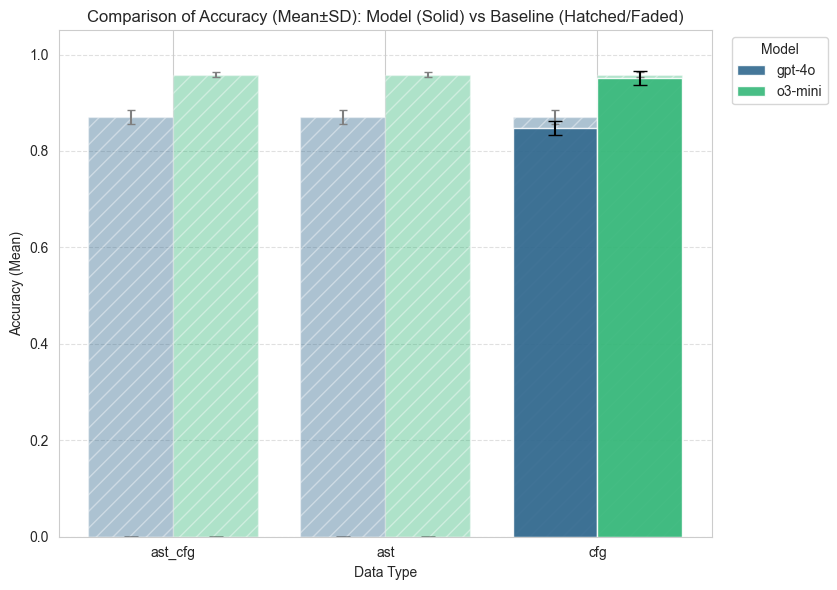

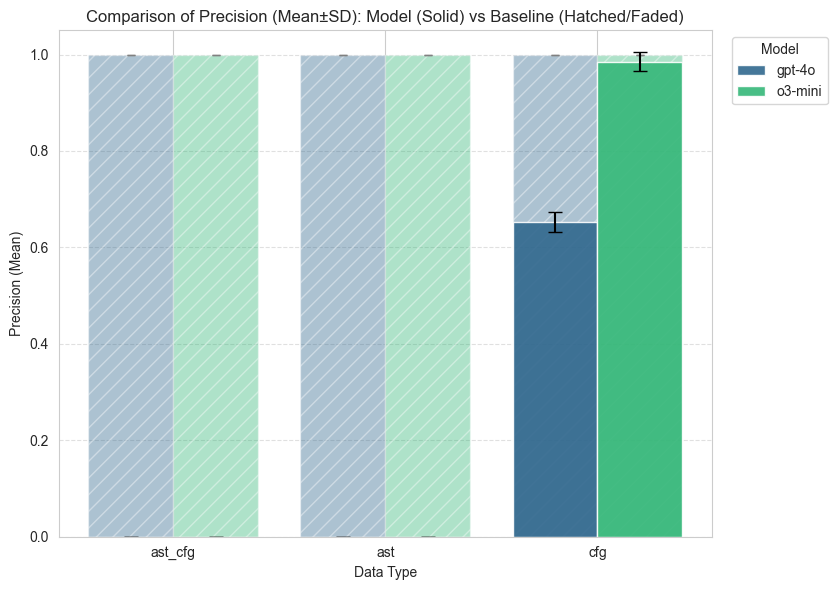

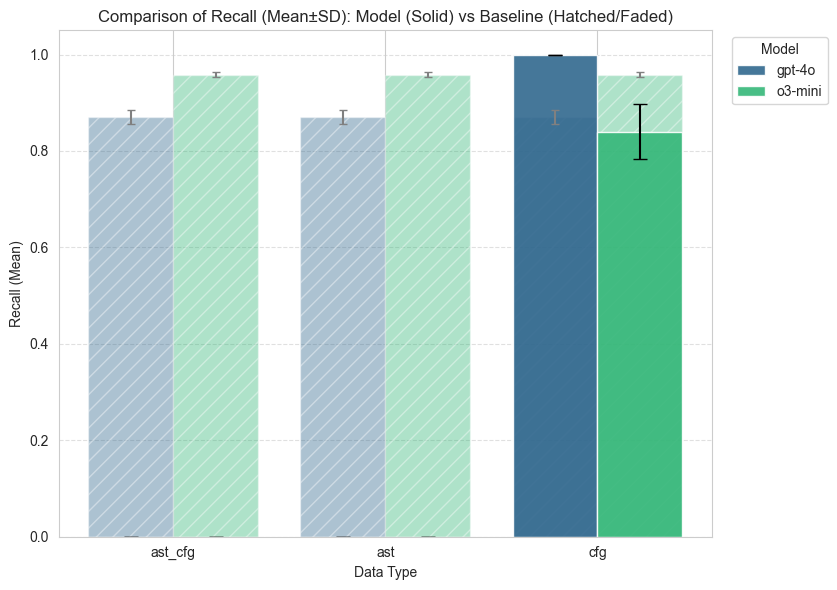

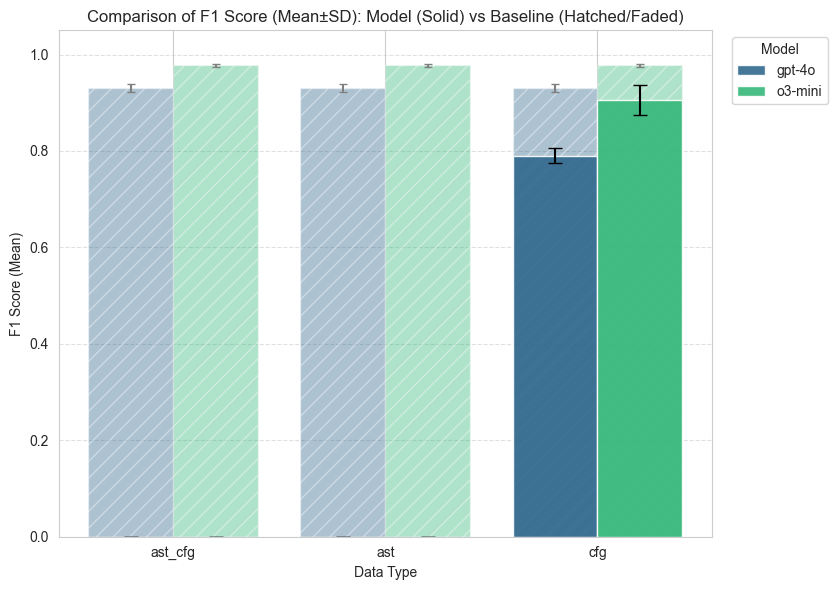

In [45]:
# Check if the results dictionaries exist and are populated
if 'final_classification_results' not in locals() or not isinstance(final_classification_results,
                                                                    dict) or not final_classification_results:
    logger.error("Error: 'final_classification_results' dictionary not found, is not a dictionary, or is empty.")
elif 'baseline_results' not in locals() or not isinstance(baseline_results, dict):
    logger.error("Error: 'baseline_results' dictionary not found or is not a dictionary (can be empty).")
# Check if essential configuration lists exist
elif 'data_types' not in locals() or not data_types:
    logger.error("Error: 'data_types' list not found or is empty.")
elif 'monitored_metrics' not in locals() or not monitored_metrics:
    logger.error("Error: 'monitored_metrics' list not found or is empty.")
else:
    # Filter models based on the original criteria
    models = [
        m for m in final_classification_results.keys()
        if not ("_k" in m or m.startswith("r"))  # Adjust filter if needed
    ]

    # Proceed only if there are models left after filtering
    if not models:
        logger.warning("No models match the filter criteria. No plots will be generated.")
    else:
        logger.info(f"Plotting for models: {models}")
        logger.info(f"Using data types: {data_types}")
        logger.info(f"Plotting metrics: {monitored_metrics}")

        # Check the exact name of the DataType column in the first valid model's DataFrame
        first_df = final_classification_results[models[0]]
        if "DataType" in first_df.columns:
            data_type_col_name = "DataType"
        elif "Data Type" in first_df.columns:
            data_type_col_name = "Data Type"
        else:
            logger.error("Could not find 'DataType' or 'Data Type' column in DataFrames. Cannot proceed.")
            models = []  # Prevent further processing

    # Loop through each metric to create a separate plot
    for metric in monitored_metrics:
        if not models:  # Skip if no models or if DataType column check failed
            break

        plt.figure(figsize=(10, 6))  # Adjust figure size as needed

        # Define the column names for mean and standard deviation
        mean_col = f"{metric}_mean"
        std_col = f"{metric}_std"

        # Basic check if mean/std columns exist in the first model's DataFrame (for main results)
        first_model_df = final_classification_results[models[0]]
        if mean_col not in first_model_df.columns or std_col not in first_model_df.columns:
            logger.warning(
                f"Main result columns '{mean_col}' or '{std_col}' not found in DataFrame for model '{models[0]}'. Skipping plot for metric '{metric}'.")
            plt.close()
            continue

        x = np.arange(len(data_types))  # Base positions for the data types on the x-axis
        num_models = len(models)
        total_width_per_group = 0.8  # Total width for all bars for one data type
        width_per_bar = total_width_per_group / num_models  # Width of a single bar

        # Get distinct colors for each model and store them
        model_colors = {model: color for model, color in zip(models, sns.color_palette("viridis", num_models))}

        # --- Plot Baseline Bars First (Faded, Hatched, With Error Bars, No Label) ---
        for i, model in enumerate(models):
            # Get the baseline mean and std dev for this model and metric (assuming 'overall' structure)
            baseline_mean = baseline_results.get(model, {}).get('overall', {}).get(mean_col, np.nan)
            baseline_std = baseline_results.get(model, {}).get('overall', {}).get(std_col, np.nan)  # Get std dev

            if np.isnan(baseline_mean):
                logger.warning(
                    f"Baseline mean for model '{model}', metric '{metric}' not found. Skipping baseline bar.")
                # Skip plotting if mean is NaN
                continue
            # If std dev is NaN but mean is valid, default std dev to 0 for plotting
            if np.isnan(baseline_std):
                logger.warning(
                    f"Baseline std dev for model '{model}', metric '{metric}' not found. Plotting baseline bar with 0 std dev.")
                baseline_std = 0

            # Create lists of baseline values, repeated for each data type
            baseline_means_list = [baseline_mean] * len(data_types)
            baseline_stds_list = [baseline_std] * len(data_types)  # Create list for std dev

            # Calculate the precise x-position for this model's bars
            bar_position = x - (total_width_per_group / 2) + (i * width_per_bar) + (width_per_bar / 2)

            color = model_colors.get(model, "gray")  # Use stored color

            plt.bar(bar_position,
                    baseline_means_list,
                    width_per_bar,
                    yerr=baseline_stds_list,  # Add baseline error bars
                    alpha=0.4,  # Lower alpha for baseline
                    color=color,
                    error_kw=dict(ecolor='gray'),
                    capsize=3,  # Slightly smaller capsize for baseline
                    hatch='//')  # Add hatching for distinction
            # No label here

        # --- Plot Main Bars Second (Solid, With Label and Error Bars) ---
        for i, model in enumerate(models):
            model_df = final_classification_results[model]
            mean_values = []
            std_devs = []

            # Gather mean and std dev for the current model across all data types
            for dt in data_types:
                row = model_df.loc[model_df[data_type_col_name] == dt]
                if not row.empty:
                    mean_val = row.iloc[0].get(mean_col, np.nan)
                    std_val = row.iloc[0].get(std_col, np.nan)
                    mean_values.append(mean_val)
                    # Default std dev to 0 if NaN but mean is valid
                    std_devs.append(std_val if not np.isnan(std_val) else 0)
                else:
                    mean_values.append(np.nan)
                    std_devs.append(np.nan)
                    logger.warning(f"Model '{model}': DataType '{dt}' row not found. Plotting NaN.")

            # Calculate the precise x-position for this model's bars (same as baseline)
            bar_position = x - (total_width_per_group / 2) + (i * width_per_bar) + (width_per_bar / 2)
            color = model_colors.get(model, "gray")  # Use stored color

            # Plot the main bars with error bars
            plt.bar(bar_position,
                    mean_values,
                    width_per_bar,
                    yerr=std_devs,  # Use collected standard deviations
                    label=model,  # Label for the legend
                    alpha=0.9,  # Higher alpha for main bars
                    color=color,  # Use the model's assigned color
                    capsize=5)  # Larger capsize for main error bars

        # --- Formatting the plot ---
        plt.ylim([0, 1.05])  # Set Y-axis limits
        # Set x-ticks to be centered under each group of bars (i.e., at data type positions)
        plt.xticks(x, data_types)
        # Update title to reflect both bars show Mean +/- SD
        plt.title(f"Comparison of {metric} (Mean±SD): Model (Solid) vs Baseline (Hatched/Faded)")
        plt.xlabel("Data Type")
        plt.ylabel(f"{metric} (Mean)")
        # Create legend (model names only)
        plt.legend(title="Model", loc='upper left', bbox_to_anchor=(1.02, 1))
        plt.grid(axis="y", linestyle="--", alpha=0.6)  # Add horizontal grid lines
        # Adjust layout to make space for the legend
        plt.tight_layout(rect=[0, 0, 0.85, 1])  # rect=[left, bottom, right, top]
        plt.show()  # Display the plot for the current metric